### Tutorial in hamiltorch for passing gradients

In [1]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(hamiltorch.__version__)

0.4.0.dev1


## Sampling a multivariate Gaussian

We will take the same example as in the notebook `hamiltorch_log_prob_examples`, but now define our own function `pass_grad` to provide our own custom gradient function to be applied instead of autograd.

As before we use the example of our multivariate Gaussian distribution, and define our `log_prob_func` as follows:

In [4]:
def log_prob(omega):
    mean = torch.tensor([0.,0.,0.])
    stddev = torch.tensor([.5,1.,2.]) 
    return torch.distributions.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

We now define our derivative function to be used instead of autograd:

In [5]:
def log_prob_grad(omega):
    mean = torch.tensor([0.,0.,0.])
    stddev = torch.tensor([.5,1.,2.])
    term1 = - torch.matmul(torch.diag(stddev**-2), (omega - mean))
    return term1

In [6]:
params_init = torch.zeros(3) + torch.randn(3)
manual = log_prob_grad(params_init)
out = log_prob(params_init.requires_grad_())
auto = torch.autograd.grad(out, params_init)[0]
# Check
print(torch.equal(auto, manual))


True


In [7]:
N = 400
step_size = .5 # This is quite large but it is also a simple Gaussian
L = 20

### Sample using standard HMC
* The only difference from before is now using the `pass_grad` option and in this case setting `pass_grad = log_prob_grad` 

In [8]:
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc_manual = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L, pass_grad=log_prob_grad)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 400/400 | 106.16       
Acceptance Rate 0.92


### Compare to default
* For default `pass_grad = None`

In [9]:
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc_auto = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 400/400 | 91.66       
Acceptance Rate 0.92


In [10]:
coords_manual = torch.cat(params_hmc_manual).reshape(len(params_hmc_manual),-1)
coords_auto = torch.cat(params_hmc_auto).reshape(len(params_hmc_auto),-1)

# Interestingly (and as expected) both samples are exactly the same which verifies that my manual gradient implementation was correct!
# I will leave more complex examples to people better at calculus!

print('Are both sets of samples equivalent?\n',
      torch.equal(coords_manual, coords_auto))


Are both sets of samples equivalent?
 True


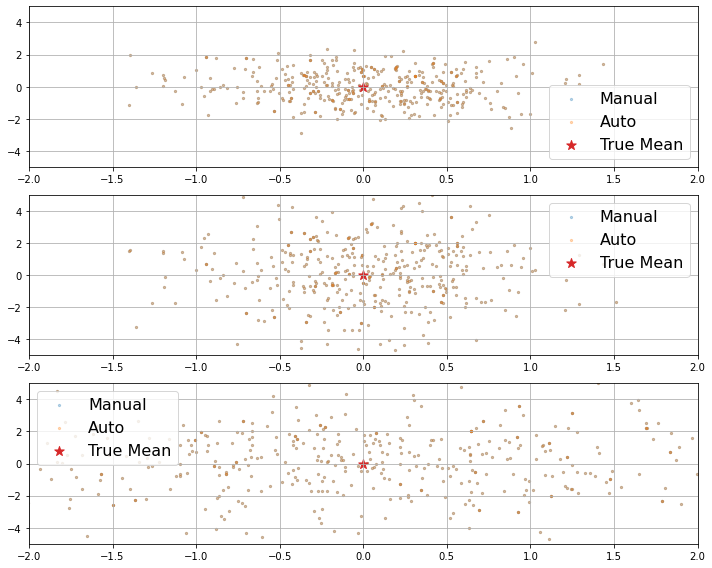

In [11]:
xlim = [-2,2]
ylim = [-5,5]
fs=16
mean = torch.tensor([0.,0.,0.])
stddev = torch.tensor([.5,1.,2.])

fig, axs = plt.subplots(3, 1, figsize=(10,8))

axs[0].scatter(coords_manual[:,0], coords_manual[:,1],s=5,alpha=0.3,label='Manual')
axs[0].scatter(coords_auto[:,0], coords_auto[:,1],s=5,alpha=0.3,label='Auto')
axs[0].scatter(mean[0],mean[1],marker = '*',color='C3',s=100,label='True Mean')
axs[0].legend(fontsize=fs)
axs[0].grid()
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].scatter(coords_manual[:,0], coords_manual[:,2],s=5,alpha=0.3,label='Manual')
axs[1].scatter(coords_auto[:,0], coords_auto[:,2],s=5,alpha=0.3,label='Auto')
axs[1].scatter(mean[0],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[1].legend(fontsize=fs)
axs[1].grid()
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

axs[2].scatter(coords_manual[:,1], coords_manual[:,2],s=5,alpha=0.3,label='Manual')
axs[2].scatter(coords_auto[:,1], coords_auto[:,2],s=5,alpha=0.3,label='Auto')
axs[2].scatter(mean[1],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[2].legend(fontsize=fs)
axs[2].grid()
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)

plt.tight_layout()

plt.show()

### KL divergence:
* Calculated the KL divergence as a measure of how well we have approximated the target distribution (the Gaussian).

In [12]:
p = torch.distributions.MultivariateNormal(mean, stddev.diag()**2)
q_manual = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_manual.mean(0)),torch.diag(torch.FloatTensor(coords_manual.var(0))))
q_auto = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_auto.mean(0)),torch.diag(torch.FloatTensor(coords_auto.var(0))))

print('Manual kl:         ',torch.distributions.kl.kl_divergence(p, q_manual))
print('Auto kl:           ',torch.distributions.kl.kl_divergence(p, q_auto))


Manual kl:          tensor(0.0044)
Auto kl:            tensor(0.0044)


### Time Comparison

* There is potential to avoid the overhead associated with `torch.autograd`. For example, my manual implementation achieved `3.94 s ± 73.8 ms per loop` compared to the autograd version: `4.85 s ± 60.1 ms per loop`. Clearly this is hardware dependent, but seems to suggest a time advantage.

In [13]:
%%timeit
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc_manual = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L, pass_grad=log_prob_grad)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 400/400 | 105.84       
Acceptance Rate 0.92
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 400/400 | 104.40       
Acceptance Rate 0.92
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 400/400 | 99.50        
Acceptance Rate 0.92
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 400/400 | 104.93       
Acceptance Rate 0.92
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | ###

In [14]:
%%timeit
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc_manual = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:05 | 0d:00:00:00 | #################### | 400/400 | 76.62       
Acceptance Rate 0.92
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 400/400 | 81.97       
Acceptance Rate 0.92
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 400/400 | 84.91       
Acceptance Rate 0.92
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 400/400 | 81.73       
Acceptance Rate 0.92
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #######